In [1]:
from __future__ import print_function, division
from builtins import range
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ALPHA = 0.1
GAMMA = 0.9
POSSIBLE_ACTIONS = ('U','D','L','R') 

In [3]:
#Environment
class Grid:
    def __init__(self, width, height, start):
        self.width = width
        self.height = height
        self.i = start[0]
        self.j = start[1]
        
    def set(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions
        
    def set_state(self, state):
        self.i = state[0]
        self.j = state[1]
        
    def current_state(self):
        return(self.i, self.j)

    def is_terminal(self, s):
        return s not in self.actions 
    
    def move(self, action):
        if action in self.actions[(self.i, self.j)]:
            if action == 'U':
                self.i -= 1
            elif action =='D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1 
        
        return self.rewards.get((self.i, self.j), 0)
        
    
    def undo_move(self):
        if action == 'U':
            self.i += 1
        elif action =='D':
            self.i -= 1
        elif action == 'R':
            self.j -= 1
        elif action == 'L':
            self.j += 1 
        
        assert(self.current_state() in self.all_states())
                
            
    def game_over(self):
        return (self.i, self.j) not in self.actions
    
    
    def all_states(self):
        return set().union(self.actions.keys(), self.rewards.keys())

    

In [4]:
def standard_grid():
    # .  .  .  1
    # .  x  .  -1
    # s  .  .  .
    
    # 1, -1 are rewards for the corresponding positions
    # 'x'  not allowed
    # 's'  start state
    grid = Grid(3, 4, (2,0))
    rewards = {(0,3) : 1, (1,3) : -1}
    actions = {
        (0, 0): ('D', 'R'),
        (0, 1): ('L', 'R'),
        (0, 2): ('L', 'D', 'R'),
        (1, 0): ('U', 'D'),
        (1, 2): ('U', 'D', 'R'),
        (2, 0): ('U', 'R'),
        (2, 1): ('L', 'R'),
        (2, 2): ('L', 'R', 'U'),
        (2, 3): ('L', 'U'),
    }
    grid.set(rewards, actions)
    return grid

In [5]:
def negative_grid(step_cost=-0.1):
    grid = standard_grid()
    grid.rewards.update({
            (0, 0): step_cost,
            (0, 1): step_cost,
            (0, 2): step_cost,
            (1, 0): step_cost,
            (1, 2): step_cost,
            (2, 0): step_cost,
            (2, 1): step_cost,
            (2, 2): step_cost,
            (2, 3): step_cost,
    })
    return grid

In [6]:
def print_values(V, grid):
    for i in range(grid.width):
        print("---------------------------")
        for j in range(grid.height):
            v = V.get((i,j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="") 
        print("")

In [7]:
def print_policy(P, grid):
    for i in range(grid.width):
        print("---------------------------")
        for j in range(grid.height):
            a = P.get((i,j), ' ')
            print("  %s  |" % a, end="")
        print("")

In [8]:
def random_action(a, eps=0.1):
    p = np.random.random()
    if p < eps:
        return np.random.choice(POSSIBLE_ACTIONS)
    else:
        return a

In [9]:
def max_dict(d):
    max_key = None
    max_val = float('-inf')

    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

Rewards
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


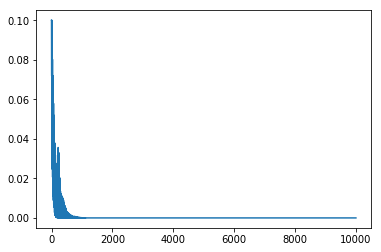

update counts:
---------------------------
 0.26| 0.05| 0.04| 0.00|
---------------------------
 0.13| 0.00| 0.01| 0.00|
---------------------------
 0.28| 0.07| 0.05| 0.11|


values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|


policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [11]:
if __name__ == '__main__':
    grid = negative_grid(step_cost=-0.1)
    
    print("Rewards")
    print_values(grid.rewards, grid)
    
    
    Q = {}
    states = grid.all_states()
    for s in states:
        Q[s] = {}
        for a in POSSIBLE_ACTIONS:
            Q[s][a] = 0
            
    update_counts = {}
    update_counts_sa = {}
    for s in states:
        update_counts_sa[s] = {}
        for a in POSSIBLE_ACTIONS:
            update_counts_sa[s][a] = 1.0
    
    
    deltas = []
    t = 1.0
    for e in range(10000):
        if e % 100 == 0:
           t+= 1e-2 
    
        s = (2,0)
        grid.set_state(s)
        
        
        a = max_dict(Q[s])[0]
        max_change = 0
        
        while not grid.game_over():
            a = random_action(a, eps=0.5/t)
                       
            r = grid.move(a)
            s_next = grid.current_state()
            
            a_next, max_q_s_next_a_next = max_dict(Q[s_next])
                        
            alpha = ALPHA / update_counts_sa[s][a]
            update_counts_sa[s][a] += 0.005
            old_qsa = Q[s][a]
            Q[s][a] = Q[s][a] + alpha *(r + GAMMA * max_q_s_next_a_next - Q[s][a])

            max_change = max(max_change, np.abs(old_qsa - Q[s][a]))
            update_counts[s] = update_counts.get(s,0) + 1

            s = s_next

        deltas.append(max_change)
        
        
    plt.plot(deltas)
    plt.show()

    # determine the policy from Q*
    # find V* from Q*
    policy = {}
    V = {}
    for s in grid.actions.keys():
        a, max_q = max_dict(Q[s])
        policy[s] = a
        V[s] = max_q


    print("update counts:")
    total = np.sum(list(update_counts.values()))
    for k, v in update_counts.items():
        update_counts[k] = float(v) / total
    print_values(update_counts, grid)


    print("\n\nvalues:")
    print_values(V, grid)

    print("\n\npolicy:")
    print_policy(policy, grid)